In [1]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import gmaps
import os
import time
import datetime

# Google developer API key
from config import gkey

# Access maps with unique API key
gmaps.configure(api_key=gkey)

In [2]:
# Creates lists for data to be stored 
date = []
place = []
mag = []
cdi = []
mmi = []
coordinates = []
lat = []
long = []

# 1906 San Francisco Earthquake Data & 30 Years Prior, Within 150km
def earthquake(e):
    params = {"starttime": "1876-01-20", "endtime": "1906-04-20",
              "minmagnitude": "4.0", "maxradiuskm":150, "latitude": 37.75, "longitude":-122.55}
    data = requests.get(e, params = params)
    data = json.loads(data.text)
    return data

e = r"https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson"
a = earthquake(e)

for i in (a["features"]):
    print(i["properties"]["time"], i["properties"]["place"],
    i["properties"]["cdi"], i["properties"]["mag"],i["properties"]["mmi"],i["geometry"]["coordinates"][0],i["geometry"]["coordinates"][1])

-2010394053700 The 1906 San Francisco Earthquake None 7.9 8.997 -122.55 37.75
-2064576840000 3 km SW of Winters, California None 4.5 None -122 38.5
-2095866660000 3 km ENE of Seven Trees, California None 5.8 None -121.8 37.3
-2100422880000 3 km S of Milpitas, California None 5.8 None -121.9 37.4
-2133926940000 5 km S of Elmira, California None 5.4 None -121.9 38.3
-2198625526000 4 km ENE of Aromas, California None 4.5 None -121.6 36.9
-2224381800000 Near Hollister, California None 5.8 None -121.4 36.9
-2227365660000 Near San Francisco, California None 5.6 None -122.5 37.7
-2230161540000 Near San Juan Bautista, California None 6 None -121.6 36.85
-2264343420000 South of Sonoma, California None 6.4 None -122.5 38.2
-2288835960000 Near Gilroy, California None 6.3 None -121.5 37
-2410785900000 Near Santa Rosa, California None 5.6 None -122.7 38.4
-2414226600000 San Pablo Bay, California None 4.6 None -122.4 38
-2451081060000 Near Dixon, California None 5.6 None -121.8 38.4
-2451795420000 N

In [3]:
# Pre-dictionary storage loop
for i in (a["features"]):
    date.append(i["properties"]["time"])
    place.append(i["properties"]["place"])
    cdi.append(i["properties"]["cdi"])
    mag.append(i["properties"]["mag"])
    mmi.append(i["properties"]["mmi"])
    lat.append(i["geometry"]["coordinates"][1])
    long.append(i["geometry"]["coordinates"][0])
    
# Create a dictionary for establishing dataframe
san_francisco = {
    "City":place,
    "Epoch Time":date,
    "Magnitude": mag,
    "MMI": mmi,
    "CDI":cdi,
    "Latitude":lat,
    "Longitude":long
}

san_fran_df = pd.DataFrame(san_francisco)
san_fran_df.head()

,City,Epoch Time,Magnitude,MMI,CDI,Latitude,Longitude
0,The 1906 San Francisco Earthquake,-2010394053700,7.9,8.997,None,37.75,-122.55
1,"3 km SW of Winters, California",-2064576840000,4.5,NaN,None,38.50,-122.00
2,"3 km ENE of Seven Trees, California",-2095866660000,5.8,NaN,None,37.30,-121.80
3,"3 km S of Milpitas, California",-2100422880000,5.8,NaN,None,37.40,-121.90
4,"5 km S of Elmira, California",-2133926940000,5.4,NaN,None,38.30,-121.90


In [4]:
# Converting epoch time to human-readable format
epoch_list = san_fran_df['Epoch Time'].tolist()
converted_list = []

for i in epoch_list:
    converted = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(i/1000.0))
    converted_list.append(converted)

In [5]:
# Adding human-readable time to DF
san_fran_df['Date'] = converted_list
san_fran_df.head()

,City,Epoch Time,Magnitude,MMI,CDI,Latitude,Longitude,Date
0,The 1906 San Francisco Earthquake,-2010394053700,7.9,8.997,None,37.75,-122.55,1906-04-18 13:12:26
1,"3 km SW of Winters, California",-2064576840000,4.5,NaN,None,38.50,-122.00,1904-07-30 10:26:00
2,"3 km ENE of Seven Trees, California",-2095866660000,5.8,NaN,None,37.30,-121.80,1903-08-03 06:49:00
3,"3 km S of Milpitas, California",-2100422880000,5.8,NaN,None,37.40,-121.90,1903-06-11 13:12:00
4,"5 km S of Elmira, California",-2133926940000,5.4,NaN,None,38.30,-121.90,1902-05-19 18:31:00


In [6]:
# Isolating coordinates for map
coordinates = san_fran_df[['Latitude', 'Longitude']]

In [7]:
# Plotting map
figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

# Adding marker layer
## TODO: Make markers interactive
markers = gmaps.marker_layer(coordinates)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='300px', margin='0 auto 0 auto', padding='1px', wi…

In [8]:
# Creating new columns to use for the bar graph
san_fran_dirty = san_fran_df
san_fran_dirty[['City', 'State']] = san_fran_df.City.str.split(",",expand=True,)
san_fran_dirty[['Dates', 'Time']] = san_fran_df.Date.str.split(" ",expand=True,)
san_fran_dirty[['Year', 'Month', 'Day']] = san_fran_df.Dates.str.split("-",expand=True,)
san_fran_dirty['Earthquake'] = san_fran_dirty['City'] + ", " + san_fran_dirty['Year']

In [9]:
# Isolating columns only necessary for bar graph
san_fran_bar = san_fran_dirty[['Earthquake', 'Magnitude']]
san_fran_bar = san_fran_bar.sort_index(ascending=False)

san_fran_bar

,Earthquake,Magnitude
29,"West of Sebastopol, 1876",4.2
28,"Southwest of Modesto, 1881",6.3
27,"Santa Cruz Mountains, 1882",5.8
26,"Near Hollister, 1883",6.0
25,"West of Santa Cruz, 1884",5.9
24,"North of Petaluma, 1888",4.2
23,"Santa Cruz Mountains, 1888",4.5
22,"San Francisco Bay area, 1888",4.3
21,"East of Gilroy, 1889",5.5
20,"North of Antioch, 1889",6.0


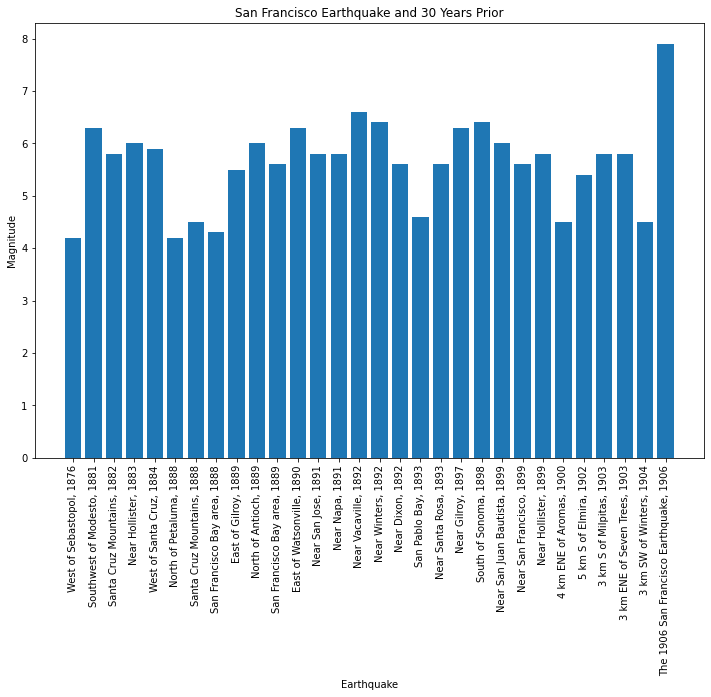

In [22]:
# Variables for Bar Chart
eq_locs = san_fran_bar['Earthquake']
eq_mag = san_fran_bar['Magnitude']

# Plotting
plt.figure(figsize=(12,8))
plt.bar(eq_locs, eq_mag)
plt.xticks(rotation=90)
plt.title('San Francisco Earthquake and 30 Years Prior')
plt.ylabel('Magnitude')
plt.xlabel('Earthquake')
plt.show()

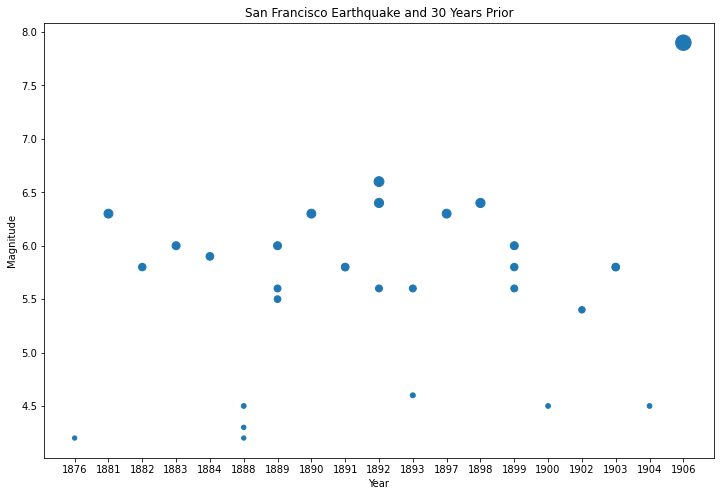

In [20]:
# Scatter DF
san_fran_scatter = san_fran_bar
san_fran_scatter['Time'] = san_fran_dirty['Year']

# Variables for Scatter Plot
eq_locs = san_fran_scatter['Earthquake']
eq_mag = san_fran_scatter['Magnitude'] 
magsize = [1*2**n for n in eq_mag]
eq_time = san_fran_scatter['Time']

# Scatter Plot
plt.figure(figsize=(12,8))
plt.scatter(eq_time, eq_mag, s=magsize)
plt.title('San Francisco Earthquake and 30 Years Prior')
plt.ylabel('Magnitude')
plt.xlabel('Year')
plt.show()